In [16]:
from graph_tool.all import *
from numpy.random import randint
from numpy.random import random
from IPython.display import Image #import to displaz images
from matplotlib import *
from gi.repository import Gtk, Gdk, GdkPixbuf, GObject, GLib
import sys, os, os.path




In [9]:
g = Graph(directed=False)

#definition of vertex properties

S = [1, 1, 1, 1]           # White color

I = [0, 0, 0, 1]           # Black color

R = [0.5, 0.5, 0.5, 1.]    # Grey color (will not actually be drawn)

V = [0, 0, 1, 1]           # Blue color

state = g.new_vertex_property("vector<double>")
age=g.new_vertex_property("int")
vac=g.new_vertex_property("bool")


agegroups=20
agegrouplists = [[] for i in range(1, agegroups+1)]


#definition of edge properties

#for not I think an edge just exists so there shouldnt be any edge properties


for v in g.vertices():
    i=randint(1,age_groups)
    vprop_age[v] = i
    

x = 0.001    # spontaneous outbreak probability

r = 0.1      # I->R probability

s = 0.01     # R->S probability






random(g.num_vertices())

random(g.num_vertices())

In [15]:
##THIS IS THE DEFINITION OF VERTICES AND ESGE PROPERTIES


#insert random vertices (nodes)
g.add_vertex(100)

# insert some random links
for s,t in zip(randint(0, 100, 100), randint(0, 100, 100)):
    g.add_edge(g.vertex(s), g.vertex(t))
    

pos = g.vp["pos"]  # layout positions

for i in g.vertices():
    v = g.vertex(i) 
    state[v] = S
    
for i in g.vertices():
    v = g.vertex(i)
    a =randint(1,agegroups)
    age[v] = a
    agegrouplists[a].append(v)

if 1 == 2:
    for i in g.vertices():
        v = g.vertex(i)
        vac[v] = False


KeyError: ('v', 'pos')

In [4]:
def update_state():

    newly_infected.a = False

    removed.a = False


    # visit the nodes in random order

    vs = list(g.vertices())

    shuffle(vs)

    for v in vs:

        if state[v] == I:

            if random() < r:

                state[v] = R

        elif state[v] == S:

            if random() < x:

                state[v] = I

            else:

                ns = list(v.out_neighbors())

                if len(ns) > 0:

                    w = ns[randint(0, len(ns))]  # choose a random neighbor

                    if state[w] == I:

                        state[v] = I

                        newly_infected[v] = True

        elif random() < s:

            state[v] = S

        if state[v] == R:

            removed[v] = True


    # Filter out the recovered vertices

    g.set_vertex_filter(removed, inverted=True)


    # The following will force the re-drawing of the graph, and issue a

    # re-drawing of the GTK window.

    win.graph.regenerate_surface()

    win.graph.queue_draw()


    # if doing an offscreen animation, dump frame to disk

    if offscreen:

        global count

        pixbuf = win.get_pixbuf()

        pixbuf.savev(r'./frames/sirs%06d.png' % count, 'png', [], [])

        if count > max_count:

            sys.exit(0)

        count += 1


    # We need to return True so that the main loop will call this function more

    # than once.

    return True


In [5]:
g.list_properties()

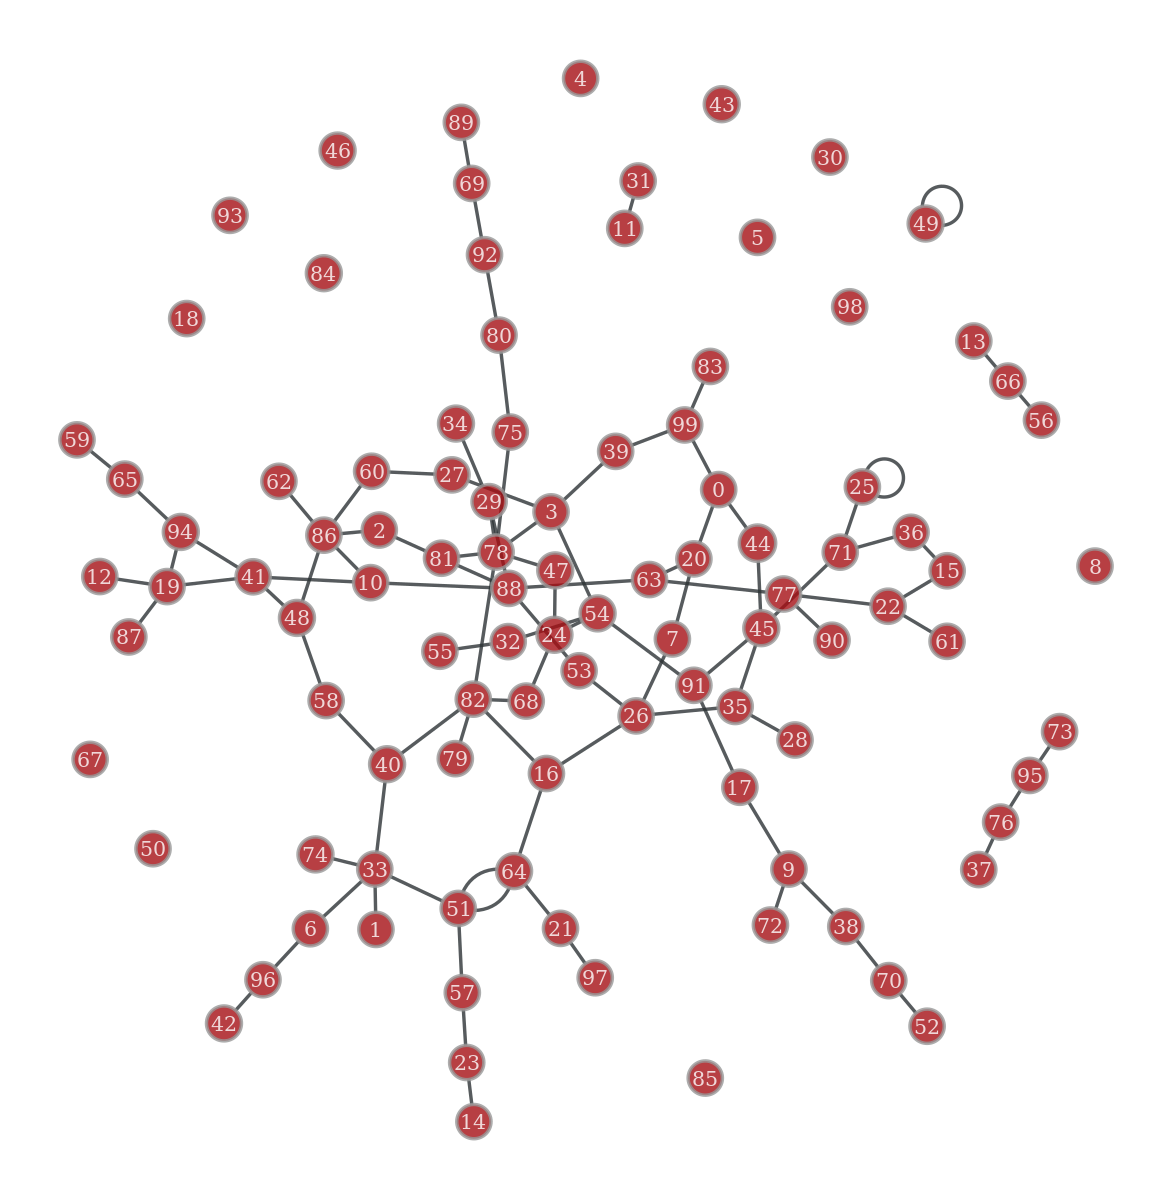

In [6]:
graph_draw(g, vertex_text=g.vertex_index, output="two-nodes.png")
fig = Image(filename=('two-nodes.png'))
fig



In [7]:
g.save("my_graph.xml.gz")
g2 = load_graph("my_graph.xml.gz")